<a href="https://colab.research.google.com/github/LeonSilva15/fcc-data-analysis/blob/main/medical_data_visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import unittest

In [2]:
!wget 'https://raw.githubusercontent.com/LeonSilva15/fcc-data-analysis/main/data/medical_examination.csv'

--2023-10-15 03:42:55--  https://raw.githubusercontent.com/LeonSilva15/fcc-data-analysis/main/data/medical_examination.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2941521 (2.8M) [text/plain]
Saving to: ‘medical_examination.csv’

medical_examination 100%[===================>]   2.80M  --.-KB/s    in 0.04s   

2023-10-15 03:42:56 (71.6 MB/s) - ‘medical_examination.csv’ saved [2941521/2941521]



In [3]:
!head medical_examination.csv

id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
8,21914,1,151,67.0,120,80,2,2,0,0,0,0
9,22113,1,157,93.0,130,80,3,1,0,0,1,0
12,22584,2,178,95.0,130,90,3,3,0,0,1,1
13,17668,1,158,71.0,110,70,1,1,0,0,1,0


In [4]:
df = pd.read_csv( 'medical_examination.csv' )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   sex          70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [73]:
# Add 'overweight' column
bmi = df[ 'weight' ] / np.square(df[ 'height' ] / 100)
df['overweight'] = (bmi > 25).astype( 'uint8' )

# Normalize data by making 0 always good and 1 always bad. If the value of 'cholesterol' or 'gluc' is 1, make the value 0. If the value is more than 1, make the value 1.
df['gluc'] = (df['gluc'] != 1).astype( 'uint8' )
df['cholesterol'] = (df['cholesterol'] != 1).astype( 'uint8' )


# Draw Categorical Plot
def draw_cat_plot():
    # Create DataFrame for cat plot using `pd.melt` using just the values from 'cholesterol', 'gluc', 'smoke', 'alco', 'active', and 'overweight'.
    # df_cat = pd.melt( df[['cholesterol', 'gluc', 'smoke', 'alco', 'active','overweight']] )
    columns = ['cholesterol', 'gluc', 'smoke', 'alco', 'active','overweight']
    df_cat = pd.melt( df, id_vars=['cardio'], value_vars=columns )


    # Group and reformat the data to split it by 'cardio'. Show the counts of each feature. You will have to rename one of the columns for the catplot to work correctly.
    df_cat = df_cat.reset_index() \
                  .groupby([ 'variable', 'cardio', 'value' ]) \
                  .agg( 'count' ) \
                  .rename( columns={ 'index': 'total' } ) \
                  .reset_index()

    # Draw the catplot with 'sns.catplot()'
    # Get the figure for the output
    fig = sns.catplot(
        x='variable',
        y='total',
        col='cardio',
        hue='value',
        data=df_cat,
        kind='bar'
    ).fig

    # Do not modify the next two lines
    fig.savefig('catplot.png')
    return fig


# Draw Heat Map
def draw_heat_map():
    # Clean the data
    # print( df.describe() )
    df_heat = df[
        # diastolic pressure is higher than systolic (incorrect)
        (df[ 'ap_lo' ] <= df[ 'ap_hi' ] )
        # height and weight off chart
        & (df[ 'height' ] >= df[ 'height' ].quantile( 0.025 ) )
        & (df[ 'height' ] <= df[ 'height' ].quantile( 0.975 ) )
        & (df[ 'weight' ] >= df[ 'weight' ].quantile( 0.025 ) )
        & (df[ 'weight' ] <= df[ 'weight' ].quantile( 0.975 ) )
    ]

    # Calculate the correlation matrix
    corr = df_heat.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like( corr )
    mask[ np.triu_indices_from( mask ) ] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Draw the heatmap with 'sns.heatmap()'
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt='.1f',
        center=0,
        vmin=-0.5,
        vmax=0.5
    )

    # Do not modify the next two lines
    fig.savefig('heatmap.png')
    return fig

In [74]:
class CatPlotTestCase(unittest.TestCase):
    def setUp(self):
        self.fig = draw_cat_plot()
        self.ax = self.fig.axes[0]

    def test_line_plot_labels(self):
        actual = self.ax.get_xlabel()
        expected = "variable"
        self.assertEqual(actual, expected, "Expected line plot xlabel to be 'variable'")
        actual = self.ax.get_ylabel()
        expected = "total"
        self.assertEqual(actual, expected, "Expected line plot ylabel to be 'total'")
        actual = []
        for label in self.ax.get_xaxis().get_majorticklabels():
            actual.append(label.get_text())
        expected = ['active', 'alco', 'cholesterol', 'gluc', 'overweight', 'smoke']
        self.assertEqual(actual, expected, "Expected bar plot secondary x labels to be 'active', 'alco', 'cholesterol', 'gluc', 'overweight', 'smoke'")

    def test_bar_plot_number_of_bars(self):
        actual = len([rect for rect in self.ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)])
        expected = 13
        self.assertEqual(actual, expected, "Expected a different number of bars chart.")


class HeatMapTestCase(unittest.TestCase):
    def setUp(self):
        self.fig = draw_heat_map()
        self.ax = self.fig.axes[0]

    def test_heat_map_labels(self):
        actual = []
        for label in self.ax.get_xticklabels():
          actual.append(label.get_text())
        expected = ['id', 'age', 'sex', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'overweight']
        self.assertEqual(actual, expected, "Expected heat map labels to be 'id', 'age', 'sex', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'overweight'.")

    def test_heat_map_values(self):
        actual = [text.get_text() for text in self.ax.get_default_bbox_extra_artists() if isinstance(text, matplotlib.text.Text)]
        print(actual)
        expected = ['0.0', '0.0', '-0.0', '0.0', '-0.1', '0.5', '0.0', '0.1', '0.1', '0.3', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.2', '0.1', '0.0', '0.2', '0.1', '0.0', '0.1', '-0.0', '-0.1', '0.1', '0.0', '0.2', '0.0', '0.1', '-0.0', '-0.0', '0.1', '0.0', '0.1', '0.4', '-0.0', '-0.0', '0.3', '0.2', '0.1', '-0.0', '0.0', '0.0', '-0.0', '-0.0', '-0.0', '0.2', '0.1', '0.1', '0.0', '0.0', '0.0', '0.0', '0.3', '0.0', '-0.0', '0.0', '-0.0', '-0.0', '-0.0', '0.0', '0.0', '-0.0', '0.0', '0.0', '0.0', '0.2', '0.0', '-0.0', '0.2', '0.1', '0.3', '0.2', '0.1', '-0.0', '-0.0', '-0.0', '-0.0', '0.1', '-0.1', '-0.1', '0.7', '0.0', '0.2', '0.1', '0.1', '-0.0', '0.0', '-0.0', '0.1']
        self.assertEqual(actual, expected, "Expected different values in heat map.")


test_bar_plot_number_of_bars (__main__.CatPlotTestCase) ... ok
test_line_plot_labels (__main__.CatPlotTestCase) ... ok
test_heat_map_labels (__main__.HeatMapTestCase) ... ok
test_heat_map_values (__main__.HeatMapTestCase) ... ok

----------------------------------------------------------------------
Ran 4 tests in 3.125s

OK


['0.0', '0.0', '-0.0', '0.0', '-0.1', '0.5', '0.0', '0.1', '0.1', '0.3', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.2', '0.1', '0.0', '0.2', '0.1', '0.0', '0.1', '-0.0', '-0.1', '0.1', '0.0', '0.2', '0.0', '0.1', '-0.0', '-0.0', '0.1', '0.0', '0.1', '0.4', '-0.0', '-0.0', '0.3', '0.2', '0.1', '-0.0', '0.0', '0.0', '-0.0', '-0.0', '-0.0', '0.2', '0.1', '0.1', '0.0', '0.0', '0.0', '0.0', '0.3', '0.0', '-0.0', '0.0', '-0.0', '-0.0', '-0.0', '0.0', '0.0', '-0.0', '0.0', '0.0', '0.0', '0.2', '0.0', '-0.0', '0.2', '0.1', '0.3', '0.2', '0.1', '-0.0', '-0.0', '-0.0', '-0.0', '0.1', '-0.1', '-0.1', '0.7', '0.0', '0.2', '0.1', '0.1', '-0.0', '0.0', '-0.0', '0.1']


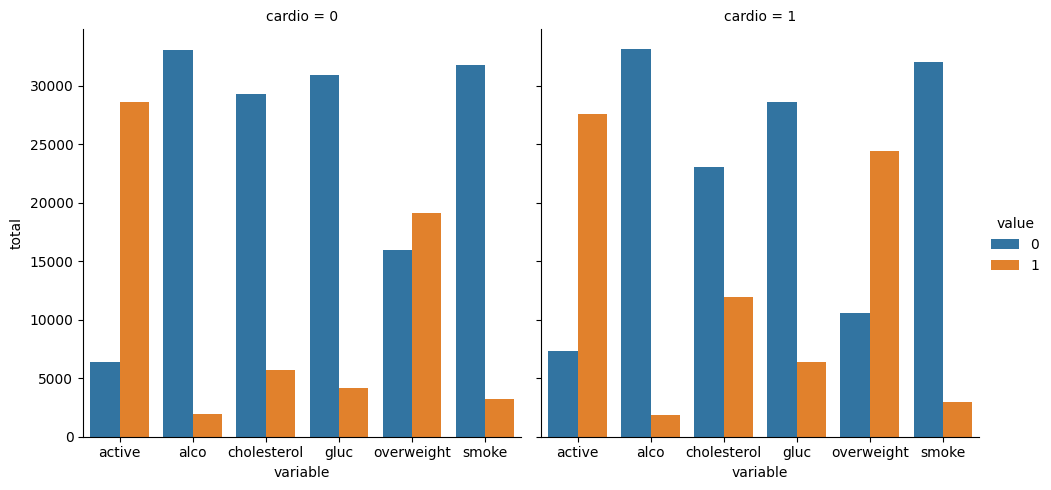

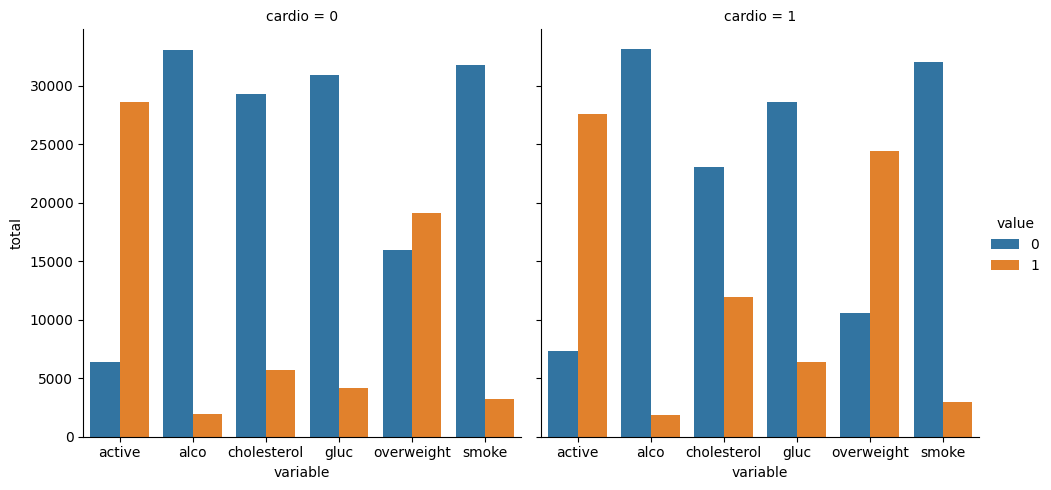

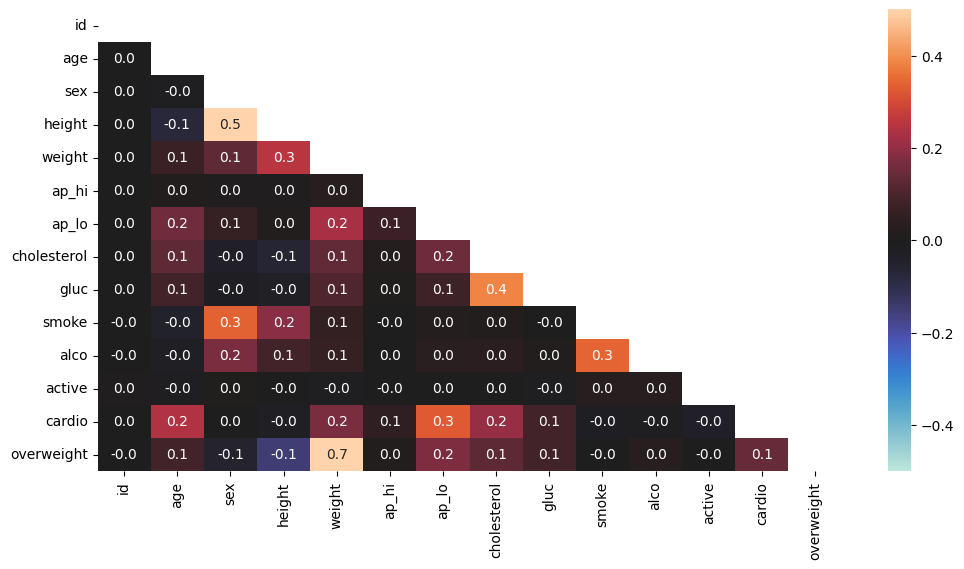

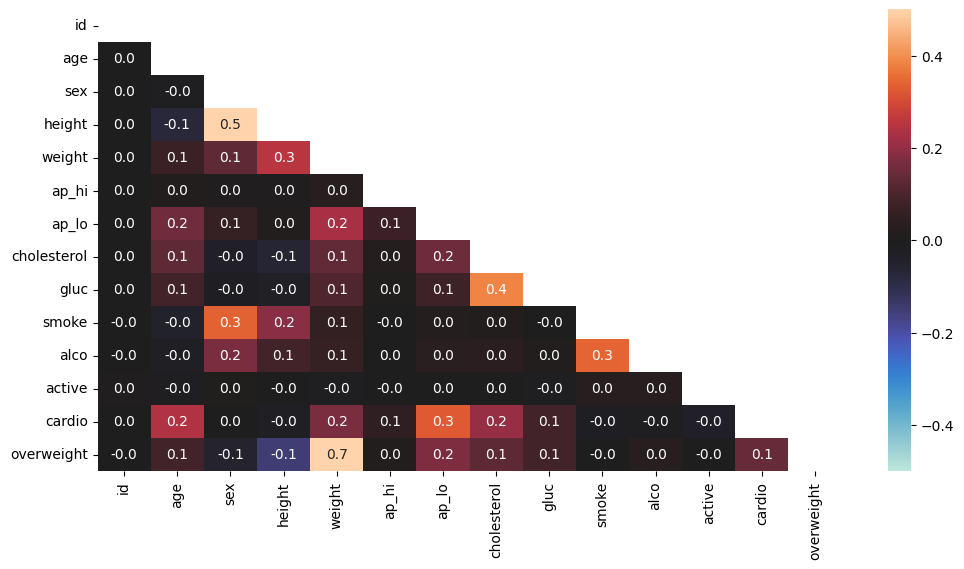

In [75]:
# Run unit tests
unittest.main( argv=[''], verbosity=2, exit=False )